### Importing Python libraries

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import re
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import TextVectorization
import string
from keras import models
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [59]:
# Load the dataset
data = pd.read_csv('data/atis/train.tsv', sep='\t', header=None, names=['text', 'label'])

In [60]:
data.head()

,text,label
0,i want to fly from boston at 838 am and arrive...,flight
1,what flights are available from pittsburgh to ...,flight
2,what is the arrival time in san francisco for ...,flight_time
3,cheapest airfare from tacoma to orlando,airfare
4,round trip fares from pittsburgh to philadelph...,airfare


In [61]:
data.shape

(4634, 2)

In [62]:
# Basic overview
print(f"Total examples: {len(data)}")
print(f"Unique intents: {data['label'].nunique()}")
print(f"Examples per intent:\n{data['label'].value_counts()}")

Total examples: 4634
Unique intents: 22
Examples per intent:
flight                        3426
airfare                        403
ground_service                 235
airline                        148
abbreviation                   108
aircraft                        78
flight_time                     52
quantity                        49
distance                        20
city                            18
airport                         18
ground_fare                     17
flight+airfare                  17
capacity                        16
flight_no                       12
meal                             6
restriction                      5
airline+flight_no                2
ground_service+ground_fare       1
airfare+flight_time              1
cheapest                         1
aircraft+flight+flight_no        1
Name: label, dtype: int64


In [63]:
data.sample(10)

,text,label
1889,okay how about a flight on sunday from tampa t...,flight
1026,what flights are there from cleveland to miami...,flight
3275,show me all the flights from philadelphia to s...,flight
3581,how can i get from the airport in pittsburgh t...,flight
2984,what is the cost of limousine service in phila...,ground_fare
3297,thanks and what 's the last flight back from w...,flight
1841,what is the ground transport in denver,ground_service
3198,tell me about flights from st. petersburg arri...,flight
3468,show me all the flights arriving around noon i...,flight
2564,what 's the earliest flight i can get between ...,flight


In [64]:
data.loc[data.label=="abbreviation"]

,text,label
47,what is fare code h,abbreviation
55,what is booking class c,abbreviation
70,what does fare code q mean,abbreviation
142,what is fare code qw,abbreviation
223,what does the fare code f mean,abbreviation
...,...,...
4308,explain meal codes sd d,abbreviation
4325,explain the fare codes,abbreviation
4432,what does ap57 mean,abbreviation
4449,what is the meaning of restriction ap80,abbreviation


In [65]:
data.loc[data.label=="distance"]

,text,label
40,how far is it from orlando airport to orlando,distance
94,what is the distance from los angeles internat...,distance
503,tell me distance from orlando airport to the city,distance
766,how far is downtown from the airport in dallas,distance
886,how long does it take to get from atlanta airp...,distance
1206,how long does it take to get from kansas city ...,distance
1552,what is the distance between pittsburgh airpor...,distance
1857,how long does it take to fly from boston to at...,distance
2195,how far is the airport from san francisco,distance
2269,what is the distance from la guardia to new yo...,distance


In [66]:
data.groupby('label').first()

,text
label,
abbreviation,what is fare code h
aircraft,what kind of aircraft is used on a flight from...
aircraft+flight+flight_no,i want to fly from detroit to st. petersburg o...
airfare,cheapest airfare from tacoma to orlando
airfare+flight_time,show me the costs and times for flights from s...
airline,which airline serves denver pittsburgh and atl...
airline+flight_no,airline and flight number from columbus to min...
airport,what 's the airport at orlando
capacity,how many seats in a 100


In [67]:
data.iloc[0:1]["text"].tolist()

['i want to fly from boston at 838 am and arrive in denver at 1110 in the morning']

### Exploratory Data Analysis

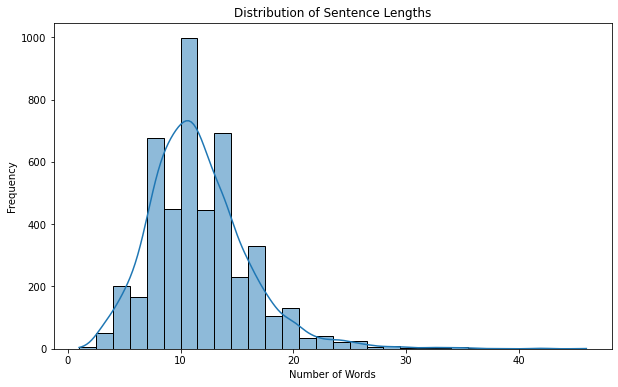

In [68]:
# Sentence length analysis
data['text_len'] = data['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(data['text_len'], bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

#### Comment 
- The maximum length of the sentences are less than 50 
- The majority of samples length is between 8 to 15

In [69]:
# Vocabulary size
all_words = ' '.join(data['text']).split()
word_count = Counter(all_words)
print(f"Total unique words: {len(word_count)}")

Total unique words: 889


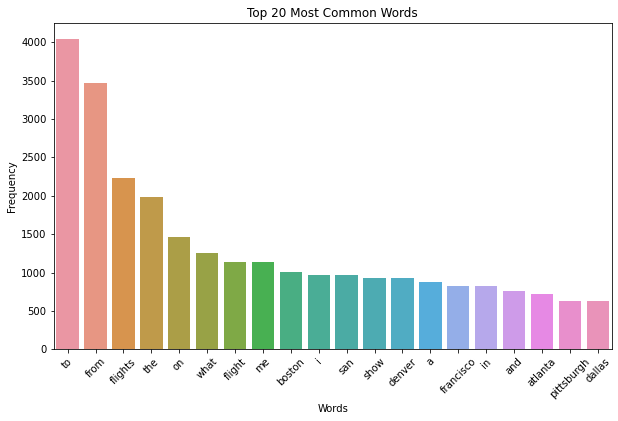

In [70]:
# Most common words
common_words = word_count.most_common(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=[word for word, freq in common_words], y=[freq for word, freq in common_words])
plt.title('Top 20 Most Common Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

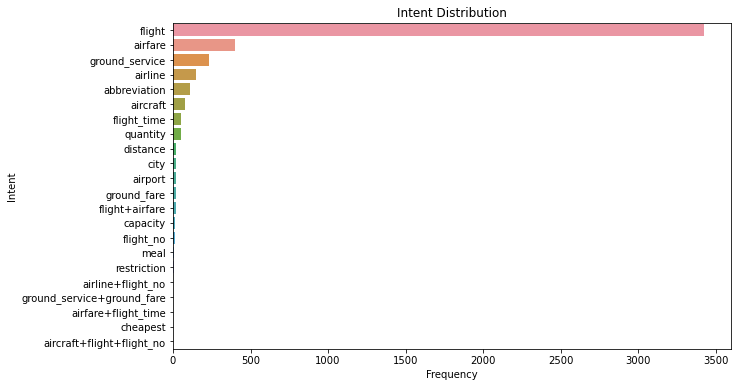

In [71]:
# Intent distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=data['label'], order=data['label'].value_counts().index)
plt.title('Intent Distribution')
plt.xlabel('Frequency')
plt.ylabel('Intent')
plt.show()

#### Comment 
- Dataset is skewed or imbalanced majority of class belongs to flight category 
- Need to apply Data Sampling, Aggregation, Agumenttaion, class weighting techniques to balance the class

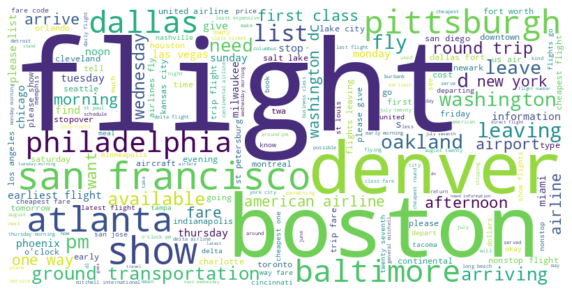

In [72]:
# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
data.label.value_counts()

flight                        3426
airfare                        403
ground_service                 235
airline                        148
abbreviation                   108
aircraft                        78
flight_time                     52
quantity                        49
distance                        20
city                            18
airport                         18
ground_fare                     17
flight+airfare                  17
capacity                        16
flight_no                       12
meal                             6
restriction                      5
airline+flight_no                2
ground_service+ground_fare       1
airfare+flight_time              1
cheapest                         1
aircraft+flight+flight_no        1
Name: label, dtype: int64

### Data Aggregation to combine similar class

In [74]:
# Class mapping dictionary
class_mapping = {
    'flight': 'flight_info',
    'flight_time': 'flight_info',
    'flight_no': 'flight_info',
    'aircraft+flight+flight_no': 'flight_info',
    'airfare': 'airfare_info',
    'flight+airfare': 'airfare_info',
    'airfare+flight_time': 'airfare_info',
    'cheapest': 'airfare_info',
    'ground_service': 'ground_service_info',
    'ground_fare': 'ground_service_info',
    'ground_service+ground_fare': 'ground_service_info',
    'airline': 'airline_info',
    'airline+flight_no': 'airline_info',
    'abbreviation': 'misc_info',
    'meal':'misc_info',
    'distance':'misc_info',
    'capacity': 'misc_info',
    'quantity': 'misc_info',
    'restriction': 'misc_info',
    'city': 'location_info',
    'airport': 'location_info'
}

In [75]:
data['label'] = data['label'].map(class_mapping).fillna(data['label'])

In [76]:
data.label.value_counts()

flight_info            3491
airfare_info            422
ground_service_info     253
misc_info               204
airline_info            150
aircraft                 78
location_info            36
Name: label, dtype: int64

In [78]:
# Perform undersampling on the 'flight' class
#data_flight_undersampled = data[data['label'] == 'flight_info'].sample(n=target_size, random_state=42)

In [79]:
# Combine with the remaining classes (which are not undersampled)
#data_remaining = data[data['label'] != 'flight_info']

In [80]:
# Concatenate the undersampled 'flight_info' class with the remaining data
#data_balanced = pd.concat([data_flight_undersampled, data_remaining])

# Shuffle the dataset
#data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [81]:
#data_balanced.label.value_counts()

In [82]:
@keras.utils.register_keras_serializable()
def custom_standardization(input_data):
    # 1. Convert to lowercase
    lowercase = tf.strings.lower(input_data)
    
    # 2. Remove punctuation
    stripped_punctuation = tf.strings.regex_replace(lowercase, f"[{re.escape(string.punctuation)}]", "")
    
    # 3. Remove extra whitespace
    return tf.strings.strip(stripped_punctuation)

In [83]:
data.shape

(4634, 3)

In [84]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

In [85]:
X_train.shape, y_train.shape

((3707,), (3707,))

In [86]:
y_train.value_counts()

flight_info            2788
airfare_info            338
ground_service_info     210
misc_info               158
airline_info            116
aircraft                 65
location_info            32
Name: label, dtype: int64

In [157]:
over_sampler = RandomOverSampler(sampling_strategy={'airfare_info':800,'ground_service_info':950,'misc_info':1500, 'airline_info':1250, 'aircraft':750, 'location_info':700},random_state=42)
X_oversampled, y_oversampled = over_sampler.fit_resample(X_train.values.reshape(-1, 1), y_train)
print("Number of records for X_train is ", X_train.shape)
print("Number of records for X_resampled oversampling is ",X_oversampled.shape)

Number of records for X_train is  (3707,)
Number of records for X_resampled oversampling is  (8738, 1)


In [158]:
type(X_oversampled)

numpy.ndarray

In [159]:
X_oversampled = X_oversampled.flatten()

In [160]:
X_oversampled.shape

(8738,)

In [161]:
y_oversampled.value_counts()

flight_info            2788
misc_info              1500
airline_info           1250
ground_service_info     950
airfare_info            800
aircraft                750
location_info           700
Name: label, dtype: int64

In [162]:
# One-Hot Encode the labels
encoder = OneHotEncoder(sparse=False,handle_unknown="ignore")
y_train_enc = encoder.fit_transform(y_oversampled.to_numpy().reshape(-1, 1))
y_val_enc = encoder.transform(y_val.to_numpy().reshape(-1, 1))

In [163]:
y_train_enc[0]

array([0., 0., 0., 1., 0., 0., 0.])

In [164]:
y_train_enc

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [165]:
y_train_enc.shape[1]

7

In [166]:
max_words = 1000
max_len = 50
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_words,
    output_mode="int",
    output_sequence_length=max_len,
    pad_to_max_tokens = True,
)

In [168]:
X_oversampled

array(["show me all flights from atlanta to san francisco which leave atlanta after 5 o'clock pm tomorrow",
       'all flights from washington dc to san francisco after 5 pm on november twelfth economy class',
       'i would like a us air flight from toronto to san diego with a stopover in denver please',
       ...,
       'what is the total seating capacity of all aircraft of american airlines',
       'list number of people that can be carried on each type of plane that flies between pittsburgh and baltimore',
       'how many first class flights are provided by american airlines'],
      dtype=object)

In [169]:
vectorize_layer.adapt(X_train)

In [170]:
vectorize_layer.call(["show me all flights from atlanta to san francisco which "])

<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[13,  8, 23,  4,  3, 19,  2, 12, 17, 68,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

In [171]:
# Build the LSTM model
embedding_dim = 128
lstm_units = 256

model = Sequential([
    vectorize_layer,
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    LSTM(lstm_units, return_sequences=False),
    Dropout(0.25),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(y_train_enc.shape[1], activation='softmax')
])

In [172]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [173]:
model.build(X_train.shape)

In [174]:
# Model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_4            │ (3707, 50)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (3707, 50, 128)        │       128,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (3707, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (3707, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (3707, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (3707, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (3707, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 556,039 (2.12 MB)

 Trainable params: 556,039 (2.12 MB)

 Non-trainable params: 0 (0.00 B)

In [175]:
model.get_config()

{'name': 'sequential_4',
 'trainable': True,
 'dtype': 'float32',
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (3707,),
    'dtype': 'string',
    'sparse': False,
    'name': 'input_layer_4'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'TextVectorization',
   'config': {'name': 'text_vectorization_4',
    'trainable': True,
    'dtype': 'float32',
    'max_tokens': 1000,
    'standardize': {'module': 'builtins',
     'class_name': 'function',
     'config': 'custom_standardization',
     'registered_name': 'function'},
    'split': 'whitespace',
    'ngrams': None,
    'output_mode': 'int',
    'output_sequence_length': 50,
    'pad_to_max_tokens': True,
    'sparse': False,
    'ragged': False,
    'vocabulary': None,
    'idf_weights': None,
    'encoding': 'utf-8',
    'vocabulary_size': 830},
   'registered_name': None,
   'build_config': {'input_shape': (3707,)}},
  {'module': 'keras.layers',
  

In [176]:
np.unique(y_train)

array(['aircraft', 'airfare_info', 'airline_info', 'flight_info',
       'ground_service_info', 'location_info', 'misc_info'], dtype=object)

In [177]:
# Train the model with validation
batch_size = 16
epochs = 15

history = model.fit(
    X_oversampled, y_train_enc,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val_enc),
    verbose=1,
)

Epoch 1/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.3204 - loss: 1.8373 - val_accuracy: 0.7584 - val_loss: 1.3602
Epoch 2/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 38ms/step - accuracy: 0.3257 - loss: 1.8255 - val_accuracy: 0.7584 - val_loss: 1.3743
Epoch 3/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.3322 - loss: 1.8132 - val_accuracy: 0.7584 - val_loss: 1.4140
Epoch 4/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.3298 - loss: 1.8156 - val_accuracy: 0.7584 - val_loss: 1.4616
Epoch 5/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - accuracy: 0.3183 - loss: 1.8237 - val_accuracy: 0.7584 - val_loss: 1.3814
Epoch 6/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.3167 - loss: 1.8229 - val_accuracy: 0.7584 - val_loss: 1.3893
Epoch 7/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - accuracy: 0.3442 - loss: 1.7652 - val_accuracy: 0.6764 - val_loss: 0.9342
Epoch 8/15
547/547 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.5741 - loss: 1.0753 - 

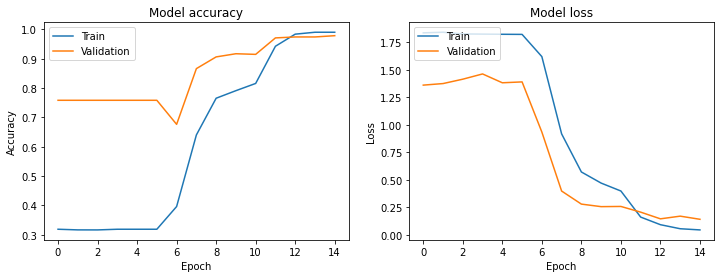

In [178]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [179]:
model.save("intent_classification1.keras")

In [180]:
loaded_model = models.load_model('intent_classification1.keras')

In [181]:
# Test the model on a separate test set
test_data = pd.read_csv('data/atis/test.tsv', sep='\t', header=None, names=['text', 'label'])

In [182]:
X_test = test_data["text"]

In [183]:
test_data['label'] = test_data['label'].map(class_mapping).fillna(test_data['label'])

In [184]:
#test_data['text'] = test_data['text'].apply(preprocess_text)

In [185]:
#X_test_seq = tokenizer.texts_to_sequences(test_data['text'])
#X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')
y_test_enc = encoder.transform(test_data['label'].to_numpy().reshape(-1, 1))

In [186]:
test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=1)

print(f'Test Accuracy: {test_acc:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9594 - loss: 0.2043
Test Accuracy: 0.9588


In [187]:
from sklearn.metrics import classification_report

# After predicting on test data
y_pred = model.predict(X_test)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [188]:
X_test.shape

(850,)

In [189]:
y_pred_labels = np.argmax(y_pred, axis=1)

In [190]:
y_pred_labels

array([3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 5, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 3, 3, 3, 3, 3, 3, 1, 1, 3, 6, 6,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 4, 4, 4, 4, 2,
       3, 3, 1, 6, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 3, 2, 2, 6, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 6, 6, 6, 6, 6, 4, 3, 3, 3, 3, 3, 2, 6,
       6, 3, 3, 3, 3, 3, 3, 3, 1, 6, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [191]:
y_true_labels = np.argmax(y_test_enc, axis=1)


In [192]:
y_true_labels

array([3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 5, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 3, 3, 5, 3, 3, 3, 1, 1, 3, 6, 6,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 4, 4, 4, 4, 2,
       3, 3, 1, 0, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 1, 2, 2, 6, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 6, 6, 6, 6, 6, 4, 3, 3, 3, 3, 3, 2, 6,
       6, 3, 3, 3, 3, 3, 3, 3, 1, 6, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 6, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [193]:
# Generate classification report
report = classification_report(y_true_labels, y_pred_labels, target_names=encoder.categories_[0])
print(report)

                     precision    recall  f1-score   support

           aircraft       0.88      0.54      0.67        13
       airfare_info       0.88      0.82      0.84        60
       airline_info       0.88      1.00      0.93        28
        flight_info       0.97      0.98      0.98       622
ground_service_info       1.00      1.00      1.00        43
      location_info       0.93      0.78      0.85        18
          misc_info       0.93      1.00      0.96        66

           accuracy                           0.96       850
          macro avg       0.92      0.87      0.89       850
       weighted avg       0.96      0.96      0.96       850



In [194]:
encoder.categories_[0]

array(['aircraft', 'airfare_info', 'airline_info', 'flight_info',
       'ground_service_info', 'location_info', 'misc_info'], dtype=object)

In [195]:
org_labels = np.array(['aircraft', 'airfare_info', 'airline_info', 'flight_info',
       'ground_service_info', 'location_info', 'misc_info'], dtype=object)